In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safe_learner import SafeActiveLearner, GPRegressionModel
import configs as cfg
%load_ext autoreload 
%autoreload 2

x_init = cfg.DOMAIN[cfg.INITIAL_SAFE_INDICES]
y_init = cfg.ground_truth_function(x_init) + 0.01 * torch.randn(1) # Adding noise_std=0.01
print(y_init.shape)
# y_init = y_init.squeeze()
# print(y_init.shape)


# 4. Initialize Learner
# Using parameters from main.py __main__ block
learner = SafeActiveLearner(
    X_plot=cfg.DOMAIN, 
    safe_threshold=cfg.SAFE_THRESHOLD,
    noise_std=0.01,
    m_PAC=cfg.m_PAC  
)

# Load initial data
learner.add_data(x_init, y_init)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
torch.Size([1, 1])


In [6]:
# --- fit gp
learner.fit_model()

# --- Acquisition , ALGO 2
x_next, idx_next = learner.select_next_point()
print(f"Selected next point: {x_next.item():.4f}")

y_next = cfg.ground_truth_function(x_next) + 0.01 * torch.randn(1)
y_next = y_next.flatten()

learner.add_data(x_next, y_next)


Getting PAC bounds now...
500
Updated B: 16.1110
Selected next point: 0.1005


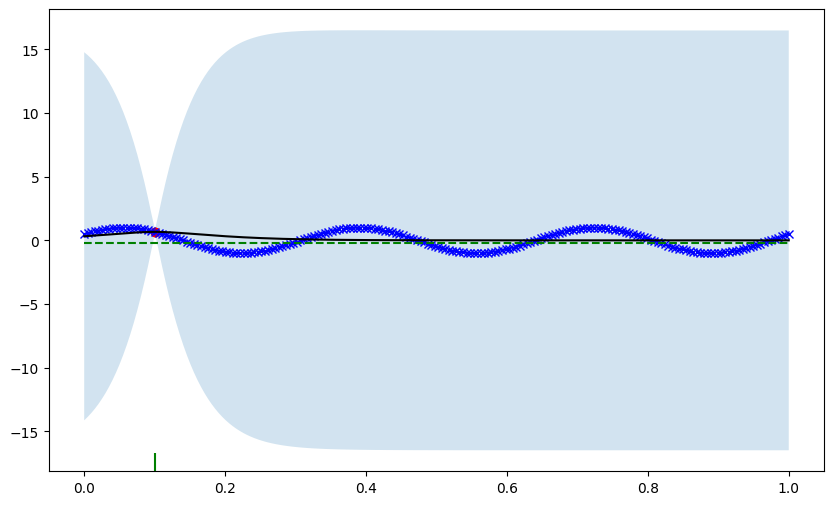

In [7]:
import matplotlib.pyplot as plt
import numpy as np
train_x, train_y = learner.get_data()
mean, cov = learner.get_posterior_mean_var()
S_mask, Q_lower, Q_upper = learner.get_safe_set_and_bounds()
plt.figure(figsize=(10,6))
ax = plt.gca()
trans = ax.get_xaxis_transform()
safe_x = cfg.DOMAIN[S_mask]
ax.scatter(
        safe_x,
        np.full_like(safe_x, 0.02),  
        marker='|',
        color='green',
        s=150,                     
        label='Safe Points',
        transform=trans           
    )
plt.plot(train_x.numpy(), train_y.numpy(), 'ro', label='Training Data')
plt.plot(cfg.DOMAIN.numpy(), cfg.ground_truth_function(cfg.DOMAIN).numpy(), 'bx--', label='Ground Truth')
plt.plot(cfg.DOMAIN.numpy(), mean.detach().numpy(), 'k-', label='GP Mean')
plt.plot(cfg.DOMAIN.numpy(), cfg.SAFE_THRESHOLD * torch.ones_like(cfg.DOMAIN).numpy(), 'g--', label='Safety Threshold')
plt.fill_between(cfg.DOMAIN.numpy().flatten(), Q_lower.detach().numpy(), Q_upper.detach().numpy(), alpha=0.2, label='Q Bounds')

In [8]:
# plot 
# --- STEP 5: Visualization ---
plt.figure(figsize=(12, 6))

# Plot Uncertainty Bounds (LCB/UCB)
plt.fill_between(
    cfg.domain.flatten().numpy(), 
    learner.lcb.detach().numpy(), 
    learner.ucb.detach().numpy(), 
    color='blue', alpha=0.2, label='Confidence Interval (SafeOpt bounds)'
)
plt.plot(cfg.domain.numpy(), learner.mean.detach().numpy(), 'b-', label='GP Mean')

# Plot Safe Threshold
plt.axhline(y=cfg.SAFE_THRESHOLD, color='r', linestyle='--', label='Safety Threshold')

# Plot Safe Set (Green dots on the threshold line)
safe_indices = learner.S.numpy()
plt.scatter(
    cfg.domain[safe_indices], 
    np.full(sum(safe_indices), cfg.SAFE_THRESHOLD), 
    color='green', s=1, marker='|', label='Safe Set (St)'
)

# Plot Observed Data
plt.scatter(learner.x_sample[:-1], learner.y_sample[:-1], c='black', marker='x', label='Previous Data')
plt.scatter(x_next, y_next, c='red', marker='*', s=150, zorder=10, label='Latest Query')

plt.title(f"Iter: {len(learner.y_sample)} | Est. RKHS Norm (B): {learner.B:.4f} | Beta: {learner.beta.item():.2f}")
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()

AttributeError: module 'configs' has no attribute 'domain'

<Figure size 1200x600 with 0 Axes>